# Cyber Security Application - Detecting Linux system hacking activities
Investigating the open data from the Cyber Range Labs of UNSW
Canberra and build models based on the data to identify abnormal system behaviour. In
addition, integrate the machine learning models into the streaming
platform using Apache Kafka and Apache Spark Streaming to detect any real-time threats, in
order to stop the hacking.

## Part - A -- Creating Models to identify cyber attacks
Here I am processing the static data and training machine learning models based on them.
Part A of the project consists of preparing the data, performing data exploration and extracting features, building and persisting the machine learning models.

Developer: **Rakesh Nain**

## Table of Contents

* [Important imports](#one)
* [1. Data preparation and exploration (35%)](#1)
    * [1.1 Creating Spark Session (4%)](#1.1)
    * [1.2 Loading the data (16%)](#1.2)
    * [1.3 Exploring the data (15%) ](#1.3)
* [2. Feature extraction and ML training (55%)](#2)        
    * [2.1 Preparing the training data and testing data (4%)](#2.1)
    * [2.2 Preparing features, labels and models (16%)](#2.2)
    * [2.3 Training and evaluating models (35%)](#2.3)
* [3. Knowledge sharing (10%)](#3)
    * [3.1 How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training. (0.5%) ](#3.1)
    * [3.2. Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents (9.5%)](#3.2)

### Information on Dataset
Four data files recorded from Linux systems are provided, which captures information
relating to the memory activity, and process activity. They are a subset of the Internet of
Things dataset collected by Dr. Nour Moustafa, from IoT devices, Linux systems, Windows
systems, and network devices. For more detailed information on the dataset, please refer to
the Metadata file included in my [GitHub repository](https://github.com/RakeshNain/Cyber-Security-Application---Detecting-Linux-system-hacking-activities.git) or from the website https://ieee-dataport.org/documents/toniot-datasets.

### Download Data for this project from my [Drive](https://drive.google.com/drive/folders/14NkpX2hKXTwFq_6v-rXLZIUCrVmjOo4s?usp=sharing)

In this website, the memory activity and the process activity data are provided
separately, without explicit linkage or computer ID to link up memory and process. For each
data, there is a binary label and a multi-class label, one for indicating whether the activity is
an attack or not, and the other for indicating which kind of attack the activity is under.

### What is Part-A of project is trying to achive?
Build separate models for the memory activity and the process activity. Each activity needs a model for a binary classification or predicting weather it is an attack or not.
To build the binary classification model, using the column “attack” as label in the model (label 0 as
non-attack event, and label 1 as attack event).

## Architecture of whole project
The overall architecture of the project is represented by the following figure. Part
A of the project consists of preparing the data, performing data exploration and
extracting features, building and persisting the machine learning models.

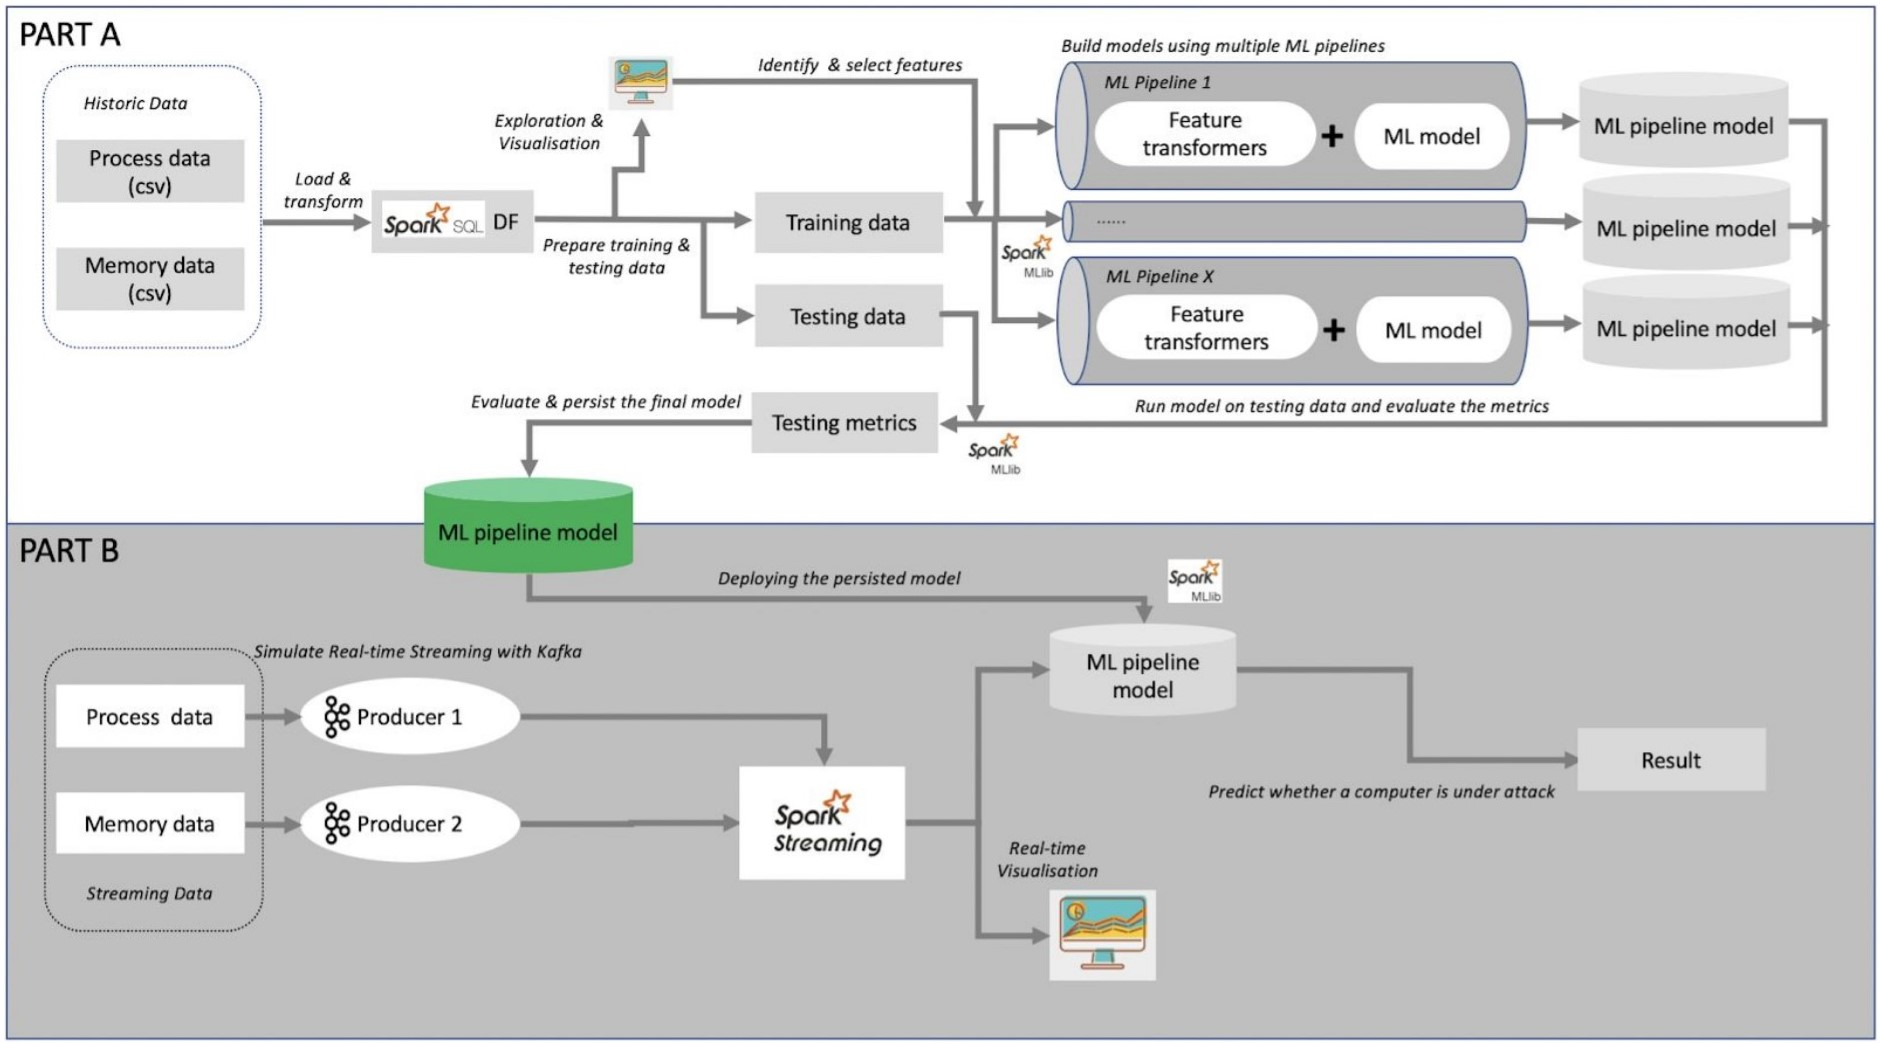

In both parts, for the data pre-processing, the machine learning processes, I have implement the solutions using PySpark SQL / MLlib / ML packages.

### Important imports <a class="anchor" id="one"></a>

In [3]:
# Import SparkConf class into program
from pyspark import SparkConf

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

from pyspark.sql.types import *

from pyspark.sql.functions import *

import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler


from pyspark.ml import Pipeline
 
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics as bcm
import pandas as pd

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel

from pyspark.ml.clustering import KMeans

from sklearn.metrics import roc_curve, auc

### Data preparation and exploration <a class="anchor" id="1"></a>
#### Creating Spark Session <a class="anchor" id="1.1"></a>

Creating a SparkConf object for using as many local cores as possible, with a proper application name, and for changing the max partition byte configuration to enable a minimum of partitions when reading each file in Spark SQL (so each dataframe should have at least 4 partitions when reading from the given datafiles).

In [4]:
# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Machine learning models to find hackers"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)


# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).config("spark.sql.files.maxPartitionBytes", 31000000).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

#### Loading the data <a class="anchor" id="1.2"></a>

Loading each activity data into a Spark dataframe and caching the data. Then printing out the row count of each dataframe.

- In order to speed up the loading process, specifying the schema before
  reading the data into dataframes. Note: I have found relevant schema info from the
  metadata file, however, some data may not fully comply with the
  schema. For those not comply with the schema, importing them as
  StringType and further transforming them in next steps.

In [5]:
process_dtype = [("ts", IntegerType()),("PID", IntegerType()),("TRUN", IntegerType()), 
                ("TSLPI", IntegerType()), ("TSLPU", IntegerType()), ("POLI", StringType()),
                ("NICE", IntegerType()),("PRI", IntegerType()),("RTPR", IntegerType()), 
                ("CPUNR", IntegerType()), ("Status", StringType()), ("EXC", IntegerType()),
                ("State", StringType()), ("CPU", IntegerType()), ("CMD", StringType()),
                ("attack", IntegerType()),("type", StringType())]
   
memory_dtype = [("ts", IntegerType()),("PID", IntegerType()),("MINFLT", IntegerType()), 
                ("MAJFLT", IntegerType()), ("VSTEXT", IntegerType()), ("VSIZE", IntegerType()),
                ("RSIZE", IntegerType()),("VGROW", IntegerType()),("RGROW", IntegerType()), 
                ("MEM", IntegerType()), ("CMD", StringType()), ("attack", IntegerType()),
                ("type", StringType())]    

process_fields = [StructField(field_name[0], field_name[1], True) for field_name in process_dtype]
memory_fields = [StructField(field_name[0], field_name[1], True) for field_name in memory_dtype]


process_schema = StructType(process_fields)
memory_schema = StructType(memory_fields)


linux_process = spark.read.csv('linux_process_*.csv', header=True, schema = process_schema)
linux_memory = spark.read.csv('linux_memory_*.csv', header=True, schema = memory_schema)

In [6]:
linux_process = linux_process.cache()
print("process data total rows: ", linux_process.count())

linux_memory = linux_memory.cache()
print("memory data total rows: ", linux_memory.count())

process data total rows:  1927968
memory data total rows:  2000000


For each column in each dataframe above, checking the null data (if any) and printing out the corresponding count in each column

In [7]:
print("Null values in Process Data:")
linux_process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_process.columns]).show()

Null values in Process Data:
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|   CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|512374|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+------+---+------+----+



In [8]:
print("Null values in Memory Data:")
linux_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_memory.columns]).show()

Null values in Memory Data:
+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT| VSIZE|RSIZE|VGROW|RGROW|   MEM|CMD|attack|type|
+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+
|  0|  0|  9737|448868| 27907|523958|83545|50912|10294|302276|  0|     0|   0|
+---+---+------+------+------+------+-----+-----+-----+------+---+------+----+



<span style="color:green">
We saw many null values in 8 columns of Memory data, by further check we see that these columns types should be string because these columns contain characters such s 'K', 'M' etc. According to research and metadata, we need to load these columns as string type and then replace these characters with appropriate zeros because 'K' represents thousands, 'M' represents millions and so on.
    </span>

In [9]:
process_dtype = [("ts", IntegerType()),("PID", IntegerType()),("TRUN", IntegerType()), 
                ("TSLPI", IntegerType()), ("TSLPU", IntegerType()), ("POLI", StringType()),
                ("NICE", IntegerType()),("PRI", IntegerType()),("RTPR", IntegerType()), 
                ("CPUNR", IntegerType()), ("Status", StringType()), ("EXC", IntegerType()),
                ("State", StringType()), ("CPU", DoubleType()), ("CMD", StringType()),
                ("attack", IntegerType()),("type", StringType())]
   
memory_dtype = [("ts", IntegerType()),("PID", IntegerType()),("MINFLT", StringType()), 
                ("MAJFLT", StringType()), ("VSTEXT", StringType()), ("VSIZE", StringType()),
                ("RSIZE", StringType()),("VGROW", StringType()),("RGROW", StringType()), 
                ("MEM", StringType()), ("CMD", StringType()), ("attack", IntegerType()),
                ("type", StringType())]    

process_fields = [StructField(field_name[0], field_name[1], True) for field_name in process_dtype]
memory_fields = [StructField(field_name[0], field_name[1], True) for field_name in memory_dtype]


process_schema = StructType(process_fields)
memory_schema = StructType(memory_fields)


linux_process_updated = spark.read.csv('linux_process_*.csv', header=True, schema = process_schema)
linux_memory_updated = spark.read.csv('linux_memory_*.csv', header=True, schema = memory_schema)

In [10]:
def strip_mk(s):
    striped_s = s.replace('K', '000').replace("M", "000000").replace("G", "000000000").replace(" ", "")
    return float(striped_s)

def strip_mk_int(s):
    striped_s = s.replace('K', '000').replace("M", "000000").replace("G", "000000000").replace(" ", "")
    return int(striped_s)

def strip_gt_lt(s):
    striped_s = s.lstrip("<").rstrip(">")
    return striped_s

strip_mk_udf = udf(strip_mk, FloatType())
strip_mk_int_udf = udf(strip_mk_int, IntegerType())
strip_gt_lt_udf = udf(strip_gt_lt, StringType())



linux_memory_cleaned = linux_memory_updated.withColumn('MAJFLT',strip_mk_udf('MAJFLT')).withColumn('MINFLT',strip_mk_int_udf('MINFLT')).\
                       withColumn('VSTEXT',strip_mk_udf('VSTEXT')).withColumn('RSIZE',strip_mk_udf('RSIZE')).\
                       withColumn('VGROW',strip_mk_udf('VGROW')).withColumn('RGROW',strip_mk_udf('RGROW')).\
                       withColumn('MEM',strip_mk_udf('MEM')).withColumn('VSIZE',strip_mk_udf('VSIZE')).withColumn('CMD',strip_gt_lt_udf('CMD'))

linux_process_cleaned = linux_process_updated.withColumn('CMD', strip_gt_lt_udf('CMD'))

In [11]:
linux_memory_cleaned = linux_memory_cleaned.cache()
linux_process_cleaned = linux_process_cleaned.cache()

<span style="color:green">
Null values after cleaning:
    </span>

In [12]:
print("Null values in Memory Data:")
linux_memory_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_memory_cleaned.columns]).show()

Null values in Memory Data:
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [13]:
print("Null values in Process Data:")
linux_process_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_process_cleaned.columns]).show()

Null values in Process Data:
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



#### Exploring the data <a class="anchor" id="1.3"></a>
Finding the class imbalance by checking count of attack and non-attack in each activity based on the column “attack”, then checking the count of each kind of attack in process activity based on the column “type”.

In [14]:
memory_attack = linux_memory_cleaned.groupby('attack').agg(count(linux_memory_cleaned.attack).alias('Total'))
memory_attack.show()

+------+-------+
|attack|  Total|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [15]:
process_attack = linux_process_cleaned.groupby('attack').agg(count(linux_process_cleaned.attack).alias('Total'))
process_attack.show()

+------+-------+
|attack|  Total|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



<span style="color:green">
We see a huge class imbalace in both data sets. In both the data sets number of non-attacks are more than 7 times of attacks.
    </span>

For each numeric feature in each activity, checking the basic statistics (including count, mean, stddev, min, max)

In [16]:
linux_memory_cleaned.toPandas().describe().round(2)

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,attack
count,2.000000e+06,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.0
mean,1.556246e+09,4999.36,983.34,1104.83,46261.23,4487.53,6119.68,984.42,483.03,0.00,0.1
std,9.844634e+05,4887.31,19229.61,5156.57,658176.50,8949.54,15869.98,86169.95,1491.30,0.01,0.3
min,1.554217e+09,1007.00,0.00,0.00,0.00,0.00,-9728.00,-9392000.00,0.00,0.00,0.0
25%,1.555468e+09,2242.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,0.0
50%,1.556444e+09,2847.00,10.00,0.00,148.00,0.00,98.20,0.00,0.00,0.00,0.0
75%,1.556859e+09,4374.00,132.00,173.90,2132.00,732.30,2608.00,0.00,0.00,0.00,0.0
max,1.558356e+09,53096.00,8050000.00,107776.00,11200000.00,88040.00,216000.00,11160000.00,98920.00,0.44,1.0


In [17]:
linux_process_cleaned.toPandas().describe().round(2)

,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU,attack
count,1.927968e+06,1927968.00,1927968.00,1927968.00,1927968.00,1927968.00,1927968.00,1927968.0,1927968.00,1927968.00,1927968.00,1927968.00
mean,1.556320e+09,5068.71,0.06,3.51,0.00,4.63,111.27,0.0,1.92,0.03,0.02,0.15
std,7.713500e+05,4987.78,0.25,6.99,0.04,8.40,22.62,0.0,1.53,1.46,0.14,0.36
min,1.554217e+09,1007.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
25%,1.556192e+09,2501.00,0.00,1.00,0.00,0.00,100.00,0.0,1.00,0.00,0.00,0.00
50%,1.556498e+09,3103.00,0.00,1.00,0.00,0.00,120.00,0.0,2.00,0.00,0.00,0.00
75%,1.556796e+09,4374.00,0.00,3.00,0.00,0.00,120.00,0.0,3.00,0.00,0.01,0.00
max,1.557593e+09,53080.00,12.00,70.00,21.00,20.00,139.00,0.0,5.00,127.00,4.02,1.00


For each non-numeric feature in each activity, display the top-10 values and the corresponding counts.

For memory data:

In [18]:
linux_memory_cleaned.groupby('CMD').agg(count(linux_memory_cleaned.CMD).alias('Total CMD')).sort(col('Total CMD'), ascending=False).show(10)

+----------+---------+
|       CMD|Total CMD|
+----------+---------+
|      atop|   326030|
|   apache2|    90184|
| jfsCommit|    81714|
|  vmtoolsd|    77871|
|      Xorg|    49981|
|  nautilus|    48364|
|irqbalance|    44387|
|    compiz|    44374|
|  ostinato|    43024|
|     drone|    41392|
+----------+---------+
only showing top 10 rows



In [19]:
linux_memory_cleaned.groupby('type').agg(count(linux_memory_cleaned.type).alias('Total type')).sort(col('Total type'), ascending=False).show(10)

+---------+----------+
|     type|Total type|
+---------+----------+
|   normal|   1794377|
|      dos|     75283|
|injection|     58523|
|     ddos|     45689|
| password|     26016|
|     mitm|       112|
+---------+----------+



For process data:

In [20]:
linux_process_cleaned.groupby('State').agg(count(linux_process_cleaned.State).alias('Total')).sort(col('Total'), ascending=False).show(10)

+-----+-------+
|State|  Total|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



In [21]:
linux_process_cleaned.groupby('Status').agg(count(linux_process_cleaned.Status).alias('Total')).sort(col('Total'), ascending=False).show(10)

+------+-------+
|Status|  Total|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



In [22]:
linux_process_cleaned.groupby('POLI').agg(count(linux_process_cleaned.POLI).alias('Total')).sort(col('Total'), ascending=False).show(10)

+----+-------+
|POLI|  Total|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



In [23]:
linux_process_cleaned.groupby('type').agg(count(linux_process_cleaned.type).alias('Total')).sort(col('Total'), ascending=False).show(10)

+---------+-------+
|     type|  Total|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scanning|  38449|
|      xss|  17759|
|     mitm|    112|
+---------+-------+



In [24]:
linux_process_cleaned.groupby('CMD').agg(count(linux_process_cleaned.CMD).alias('Total')).sort(col('Total'), ascending=False).show(10)

+--------------+------+
|           CMD| Total|
+--------------+------+
|          atop|441256|
|       apache2|324549|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63458|
|gnome-terminal| 47628|
|        compiz| 44404|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



Trying to explore data more by plotting the data and visvalising it.

In [25]:
# since plotting library works only with pandas data frame that is why converting PySpark dataframe into Pandas Data Frame
full_process = linux_process_cleaned.toPandas()
full_memory = linux_memory_cleaned.toPandas()

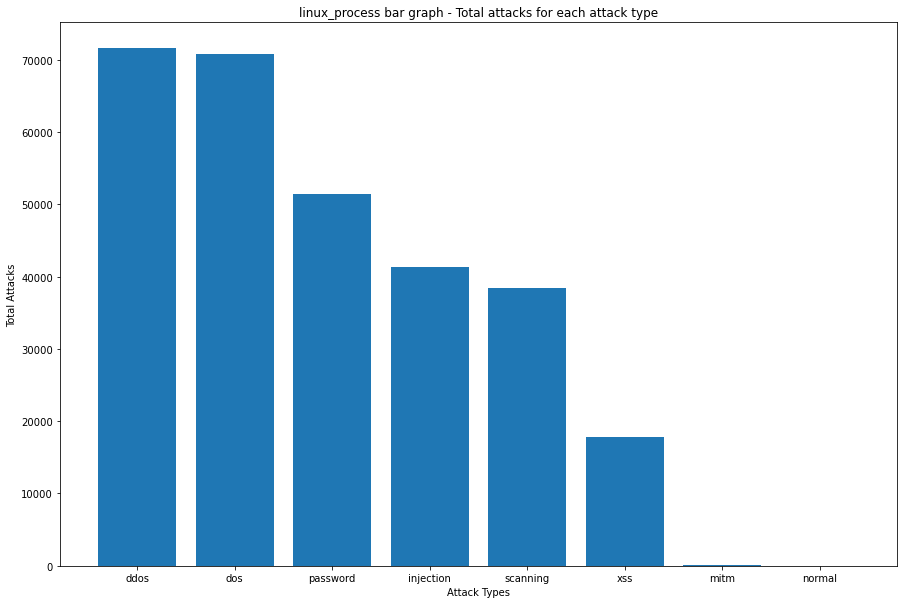

In [26]:
# bar graph with x-axis(attack types) and y-axis(Total attacks)
attack_types = linux_process_cleaned.groupBy('type').agg(sum('attack').alias('Total attacks')).sort(col('Total attacks'), ascending=False).toPandas()
plt.figure(figsize=(15,10))

plt.bar(attack_types['type'], attack_types['Total attacks'])
plt.xlabel("Attack Types", fontdict=None, labelpad=None)
plt.ylabel("Total Attacks", fontdict=None, labelpad=None)
plt.title("linux_process bar graph - Total attacks for each attack type")
plt.show()


<span style = "color: green">
This bar graph shows that according to the process data, most number of attack types are ddos and dos they both are more than 70 thousand and the least number of attack types are mitm, which are only 112. Moderate amount are of type password, injection and scanning. By this analysis we can decide priority for what type attacks must be handled 1st and then others low frequency attacks.

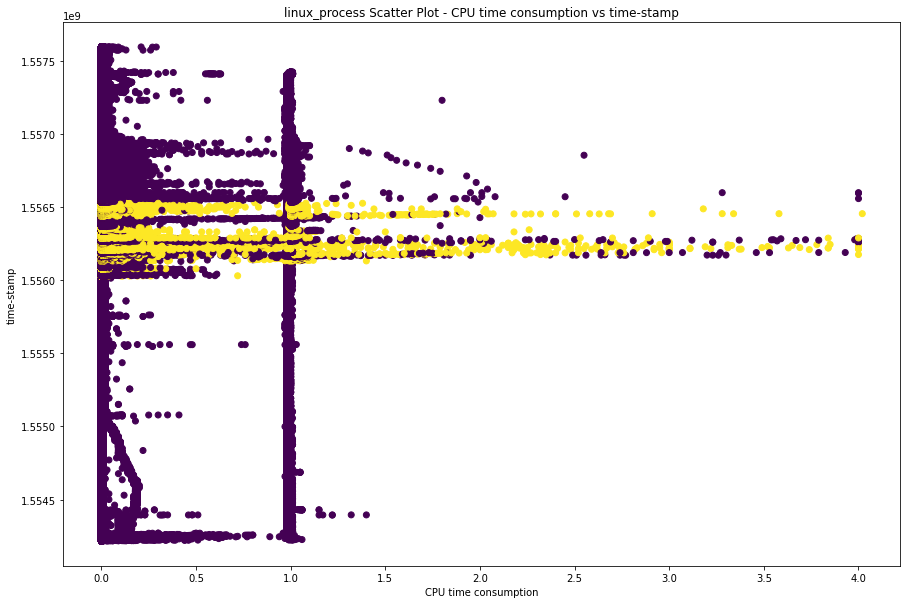

In [27]:
# scatter plot
plt.figure(figsize=(15,10))

plt.scatter(full_process["CPU"], full_process["ts"],
           c=full_process["attack"])
plt.xlabel("CPU time consumption", fontdict=None, labelpad=None)
plt.ylabel("time-stamp", fontdict=None, labelpad=None)
plt.title("linux_process Scatter Plot - CPU time consumption vs time-stamp")
plt.show()

<span style = "color: green">
This is scatter plot, where x-axis is CPU time consumption, y-axis is time-stamp and here yellow color dot shows attacks and purple color dots shows non-attacks. This scatter plot show two information, 1st it is showing that all most all the attack between time stamp $1.5560 $ 1e9 to $1.5565 $ 1e9.
    
2nd information is that we see generally if the CPU time consumption are high then the chances that the process is an attack are more as compared to the processs which have less CPU time consumptions.

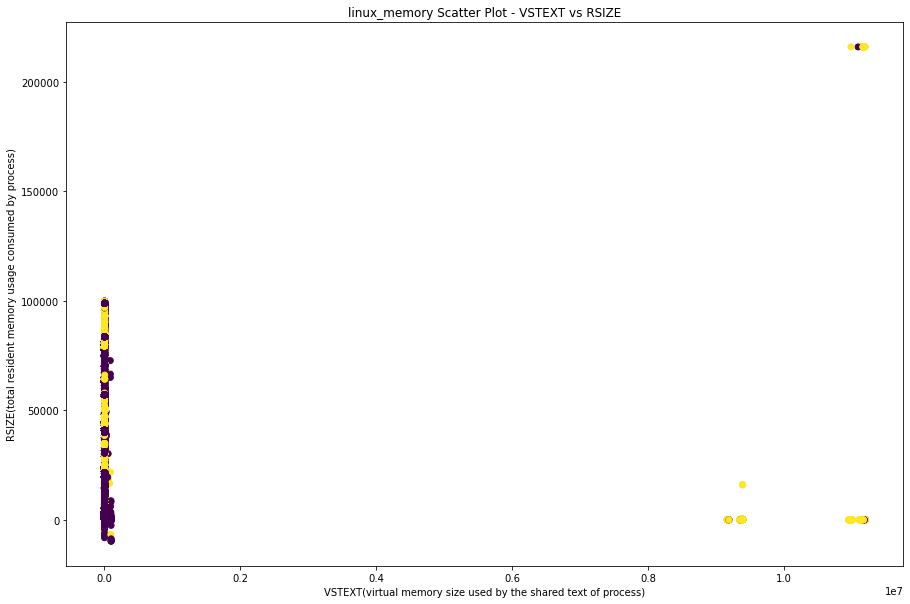

In [28]:
plt.figure(figsize=(15,10))
plt.scatter(full_memory["VSTEXT"], full_memory["RSIZE"],
           c=full_memory["attack"])
plt.xlabel("VSTEXT(virtual memory size used by the shared text of process)", fontdict=None, labelpad=None)
plt.ylabel("RSIZE(total resident memory usage consumed by process)", fontdict=None, labelpad=None)
plt.title("linux_memory Scatter Plot - VSTEXT vs RSIZE")
plt.show()

<span style = "color: green">
It is a scatter plot where x-axis is VSTEXT(virtual memory size used by the shared text of process) and y-axis is RSIZE(total resident memory usage consumed by process). The yellow dots represent attacks and purple dots represents non-attacks. This plot shows that when RSIZE is extremely big then the activity is potentially attack and also if VSTEXT is extremely big then also chance that the activity is attack are very high.

In [2]:
f = plt.figure(figsize=(10, 10))
plt.matshow(full_memory.corr(), fignum=f.number)
plt.xticks(range(full_memory.shape[1]), full_memory.columns, fontsize=14, rotation=45)
plt.yticks(range(full_memory.shape[1]), full_memory.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<span style = "color: green">
It is an correlation matrix and we can find important information from it. If two feature have very high correlation then they can be considered as reduntant feature so this correlation matrix is also usefull for feature selection. Although in our correlation matrix we do not see extremely high correaltion but few correlations should be noticed these are 'PID' and 'ts' they have negative correlation of around more than 0.52. And we can see positive correlation between VSTEXT and MINFLT of 0.45 and also positive correlation between RGROWN, ts and MEM, RSIZE is also noticeable.

### Feature extraction and ML training <a class="anchor" id="2"></a>

#### Preparing the training data and testing data <a class="anchor" id="2.1"></a>

Randomly spliting the dataset into 80% training data and 20% testing data for each use case

In [31]:
seed = 0
process_train, process_test = linux_process_cleaned.randomSplit([0.8,0.2],seed)
memory_train, memory_test = linux_memory_cleaned.randomSplit([0.8,0.2],seed)

With the class imbalance observed above, for the binary classification, preparing rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from above cached the rebalanced training data, and displaying the count of each event's data.

In [32]:
count_attack_memory = memory_train.groupBy("attack").count().orderBy("attack")

total_non_attack_memory = count_attack_memory.where(col("attack") == 0).collect()[0][1]
total_attack_memory = count_attack_memory.where(col("attack") == 1).collect()[0][1]

ration_attack_memory = (((total_attack_memory)*0.2)*2)/total_non_attack_memory

sampled_memory = memory_train.sampleBy("attack", fractions={0: ration_attack_memory, 1: 0.2}, seed=0)

memory_t = sampled_memory.cache()
memory_t.groupBy("attack").count().orderBy("attack").show()

+------+-----+
|attack|count|
+------+-----+
|     0|65472|
|     1|32954|
+------+-----+



In [33]:
count_attack_process = process_train.groupBy("attack").count().orderBy("attack")

total_non_attack_process = count_attack_process.where(col("attack") == 0).collect()[0][1]

total_attack_process = count_attack_process.where(col("attack") == 1).collect()[0][1]

ration_attack_process = (((total_attack_process)*0.2)*2)/total_non_attack_process

sampled_process = process_train.sampleBy("attack", fractions={0: ration_attack_process, 1: 0.2}, seed=0)

process_t = sampled_process.cache()
process_t.groupBy("attack").count().orderBy("attack").show()

+------+-----+
|attack|count|
+------+-----+
|     0|92570|
|     1|46812|
+------+-----+



#### Preparing features, labels and models <a class="anchor" id="2.2"></a>
              

#### Based on data exploration from above, reasearch and metadata, selected features will be:

<span style = "color: green">
For Process data:

- Selected Features
    
    - **TSLPI**: It shows number of Number of threads in state 'interruptible sleeping' (S). And we find out that closely, general trend is percentage of attacks are higher as the number of TSLPI increases.
    
    - **Status**: It is important because percentage of attacks changes according to the status, also, NC status does not have any attack. These thiungs make it an useful feature
    
    - **State**: It is important because if states are D or Z then total attack percentage is much higher as compared to other states.
    
    - **CPU**: It is important because we have seen that as the CPU increase then the percentage of attacks also increases
    
    - **CPUNR**: Current processor which is the identification of the CPU the main thread
        of the process is running on or has recently been running on, this thing make it an important identifier of attacker or         non-attacker
    - **CMD**: CMD is the name of the process and it is important becuase we have seen many CMD have 100% attack percentage that means chances of attack are very high is those CMD or processes are used.
    

<span style = "color: green">
For memory data:

- Selected Features    
    - **MINFLT**: It is the number of page faults issued by this process that have been solved
        by reclaiming the requested memory page from the free list of pages. It is important because we have seen number of MINFLT are higher than 0.5 then it is for sure is not an attack, according to the data.
        
    - **MAJFLT**: It is the number of page faults issued by this process that have been solved
        by creating/loading the requested memory page. According the scatter plot it looks like for few values of MAJFLT the percentage of attack are less as compared to other therefore this feature can be important.
        
    - **VSTEXT**: It is the virtual memory size used by the shared text of this process. And we find out that if VSTEXT is very large than chance that it is an attack are siginificantly higher.

    - **Rsize**: It is important because in some case we have then if R size is extremely high then it is definitely an attack.
    
    - **CMD**: CMD is the name of the process and it is important becuase we have seen few CMD have 100% attack percentage and many CMD have higher percentage for attack, that means chances of attack are very high if those CMD or processes are used.

#### Feature Standardising/Normalising:

<span style = "color: green">
    
Scaling of memory data is not necessary since almost all the features showing the memory used which is in byte measure, that is all the features are measured in bytes so no need to do scaling in memory data. Similarly in process data as well most of the features are showing count therefore in process data as well we do not need scaling. Normalisation is also not possible since I do not know how the data or each feature is distributed. 

#### Transformers to use:

<span style = "color: green">

I will be doing string indexer 1st because in both the data we have features in string, so we need to convert them into numbers and then after that I will be using One-Hot encoder to convert numbers into binary digits because of two reasons 1st machine learning algorithm handles binary number in a better way as compared to normal numbers and 2nd is that commands are huge in numbers so converting them into binary digits will be helpful. After One-Hot encoding I will be using Vector Assembler and at last Decision Tree or Gradient Boosting Tree.

#### Creating Machine Learning Pipelines
Preparing Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2

In [34]:
categoryInputCols_process = ['Status', 'State', 'CMD']
numericInputCols_process = ['TSLPI', 'CPU', 'CPUNR']
numericOutputCol_process = 'attack'

allNumericCols_process = numericInputCols_process + [numericOutputCol_process]

In [35]:
outputCols_index_process = [f'{x}_index' for x in categoryInputCols_process]
inputIndexer_process = StringIndexer(inputCols=categoryInputCols_process, outputCols=outputCols_index_process).setHandleInvalid("skip")

inputCols_OHE_process = outputCols_index_process
outputCols_OHE_process = [f'{x}_vec' for x in categoryInputCols_process]
encoder_process = OneHotEncoder(inputCols=inputCols_OHE_process,outputCols=outputCols_OHE_process)

assemblerInputs_process = outputCols_OHE_process + numericInputCols_process
assembler_process = VectorAssembler(inputCols = assemblerInputs_process, outputCol="features")

In [36]:
dt_process = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack')
gbt_process = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

stage_process_1 = inputIndexer_process
stage_process_2 = encoder_process
stage_process_3 = assembler_process
stage_process_dt = dt_process
stage_process_gbt = gbt_process

stages_dt_process = [stage_process_1,stage_process_2,stage_process_3,stage_process_dt]
stages_gbt_process = [stage_process_1,stage_process_2,stage_process_3,stage_process_gbt]

pipeline_dt_process = Pipeline(stages = stages_dt_process)
pipeline_gbt_process = Pipeline(stages = stages_gbt_process)

In [37]:
categoryInputCols_memory = ['CMD']
numericInputCols_memory = ['VSTEXT', 'RSIZE', 'MINFLT', 'MAJFLT']
numericOutputCol_memory = 'attack'

allNumericCols_memory = numericInputCols_memory + [numericOutputCol_memory]

In [38]:
outputCols_index = [f'{x}_index' for x in categoryInputCols_memory]
inputIndexer = StringIndexer(inputCols=categoryInputCols_memory, outputCols=outputCols_index).setHandleInvalid("skip")

inputCols_OHE = outputCols_index
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols_memory]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

assemblerInputs = outputCols_OHE + numericInputCols_memory
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

In [39]:
dt_memory = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack')
gbt_memory = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_dt = dt_memory
stage_gbt = gbt_memory

stages_dt_memory = [stage_1, stage_2, stage_3, stage_dt]
stages_gbt_memory = [stage_1, stage_2, stage_3, stage_gbt]

pipeline_dt_memory = Pipeline(stages = stages_dt_memory)
pipeline_gbt_memory = Pipeline(stages = stages_gbt_memory)

### Training and evaluating models <a class="anchor" id="2.3"></a>
For each use case, use their corresponding ML Pipeline from previous step to train the models on the rebalanced training data.

Note - each model training might take from 1min to 40min, depending on the
    complexity of the pipeline model, the amount of training data and the VM
    computing power

In [40]:
pipelineModel_dt_process = pipeline_dt_process.fit(process_t)
predictions_dt_process = pipelineModel_dt_process.transform(process_test)

pipelineModel_gbt_process = pipeline_gbt_process.fit(process_t)
predictions_gbt_process = pipelineModel_gbt_process.transform(process_test)

pipelineModel_dt_memory = pipeline_dt_memory.fit(memory_t)
predictions_dt_memory = pipelineModel_dt_memory.transform(memory_test)

pipelineModel_gbt_memory = pipeline_gbt_memory.fit(memory_t)
predictions_gbt_memory = pipelineModel_gbt_memory.transform(memory_test)

For each use case, testing the models on the testing data and displaying the count of each combination of attack label and prediction label in formats as below.

1st lets see thier confusion matrix.

In [41]:
print("Table of Decision Tree (Process Data)")
predictions_dt_process.groupBy('attack', 'prediction').count().show()

print("------------------------------------------------------------------------------------------------------------")
print("Table of GBT (Process Data)")

predictions_gbt_process.groupBy('attack', 'prediction').count().show()

print("------------------------------------------------------------------------------------------------------------")
print("Table of DT (Memory Data)")

predictions_dt_memory.groupBy('attack', 'prediction').count().show()

print("------------------------------------------------------------------------------------------------------------")
print("Table of GBT (Memory Data)")

predictions_gbt_memory.groupBy('attack', 'prediction').count().show()

Table of Decision Tree (Process Data)
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 36218|
|     0|       0.0|290084|
|     1|       1.0| 21994|
|     0|       1.0| 37595|
+------+----------+------+

------------------------------------------------------------------------------------------------------------
Table of GBT (Process Data)
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 36375|
|     0|       0.0|291642|
|     1|       1.0| 21837|
|     0|       1.0| 36037|
+------+----------+------+

------------------------------------------------------------------------------------------------------------
Table of DT (Memory Data)
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 26602|
|     0|       0.0|321717|
|     1|       1.0| 14617|
|     0|       1.0| 37367|
+------+----------+------+

---------------------------------------

Computing the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. And then discussing which metric is more proper for measuring the model performance on identifying attacks.

In [42]:
predictions_dt_process = pipelineModel_dt_process.transform(process_test)
predictions_gbt_process = pipelineModel_gbt_process.transform(process_test)
predictions_dt_memory = pipelineModel_dt_memory.transform(memory_test)
predictions_gbt_memory = pipelineModel_gbt_memory.transform(memory_test)

predictions_dt_process = predictions_dt_process.withColumn('label',col('attack').cast(IntegerType()))
predictions_gbt_process = predictions_gbt_process.withColumn('label',col('attack').cast(IntegerType()))
predictions_dt_memory = predictions_dt_memory.withColumn('label',col('attack').cast(IntegerType()))
predictions_gbt_memory = predictions_gbt_memory.withColumn('label',col('attack').cast(IntegerType()))

evaluatorMulti = MulticlassClassificationEvaluator(labelCol="attack", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

print("Area Under ROC Decision Tree (Process Data): " + str(evaluator.evaluate(predictions_dt_process, {evaluator.metricName: "areaUnderROC"})))
print("Accuracy Decision Tree (Process Data): " + str(evaluatorMulti.evaluate(predictions_dt_process, {evaluatorMulti.metricName: "accuracy"})))
print("Precision Decision Tree (Process Data): " + str(evaluatorMulti.evaluate(predictions_dt_process, {evaluatorMulti.metricName: "weightedPrecision"})))
print("Recall Decision Tree (Process Data): " + str(evaluatorMulti.evaluate(predictions_dt_process, {evaluatorMulti.metricName: "weightedRecall"})))
print("F1 Decision Tree (Process Data): " + str(evaluatorMulti.evaluate(predictions_dt_process, {evaluatorMulti.metricName: "f1"})))
print("---------------------------------------------------------------------------------------------------------")
print("Area Under ROC GBT (Process Data): " + str(evaluator.evaluate(predictions_gbt_process, {evaluator.metricName: "areaUnderROC"})))
print("Accuracy GBT (Process Data): " + str(evaluatorMulti.evaluate(predictions_gbt_process, {evaluatorMulti.metricName: "accuracy"})))
print("Precision GBT (Process Data): " + str(evaluatorMulti.evaluate(predictions_gbt_process, {evaluatorMulti.metricName: "weightedPrecision"})))
print("Recall GBT (Process Data) " + str(evaluatorMulti.evaluate(predictions_gbt_process, {evaluatorMulti.metricName: "weightedRecall"})))
print("F1 GBT (Process Data) " + str(evaluatorMulti.evaluate(predictions_gbt_process, {evaluatorMulti.metricName: "f1"})))
print("---------------------------------------------------------------------------------------------------------")
print("Area Under ROC DT (Memory Data): " + str(evaluator.evaluate(predictions_dt_memory, {evaluator.metricName: "areaUnderROC"})))
print("Accuracy DT (Memory Data): " + str(evaluatorMulti.evaluate(predictions_dt_memory, {evaluatorMulti.metricName: "accuracy"})))
print("Precision DT (Memory Data): " + str(evaluatorMulti.evaluate(predictions_dt_memory, {evaluatorMulti.metricName: "weightedPrecision"})))
print("Recall DT (Memory Data) " + str(evaluatorMulti.evaluate(predictions_dt_memory, {evaluatorMulti.metricName: "weightedRecall"})))
print("F1 DT (Memory Data) " + str(evaluatorMulti.evaluate(predictions_dt_memory, {evaluatorMulti.metricName: "f1"})))
print("---------------------------------------------------------------------------------------------------------")
print("Area Under GBT (Memory Data): " + str(evaluator.evaluate(predictions_gbt_memory, {evaluator.metricName: "areaUnderROC"})))
print("Accuracy GBT (Memory Data): " + str(evaluatorMulti.evaluate(predictions_gbt_memory, {evaluatorMulti.metricName: "accuracy"})))
print("Precision GBT (Memory Data): " + str(evaluatorMulti.evaluate(predictions_gbt_memory, {evaluatorMulti.metricName: "weightedPrecision"})))
print("Recall GBT (Memory Data) " + str(evaluatorMulti.evaluate(predictions_gbt_memory, {evaluatorMulti.metricName: "weightedRecall"})))
print("F1 GBT (Memory Data) " + str(evaluatorMulti.evaluate(predictions_gbt_memory, {evaluatorMulti.metricName: "f1"})))

Area Under ROC Decision Tree (Process Data): 0.3617213735263717
Accuracy Decision Tree (Process Data): 0.8087205972671039
Precision Decision Tree (Process Data): 0.8105758249169912
Recall Decision Tree (Process Data): 0.808720597267104
F1 Decision Tree (Process Data): 0.8096371736311924
---------------------------------------------------------------------------------------------------------
Area Under ROC GBT (Process Data): 0.7480194568448513
Accuracy GBT (Process Data): 0.8123511561554947
Precision GBT (Process Data): 0.8119028847731072
Recall GBT (Process Data) 0.8123511561554947
F1 GBT (Process Data) 0.812126338608044
---------------------------------------------------------------------------------------------------------
Area Under ROC DT (Memory Data): 0.45378522073695904
Accuracy DT (Memory Data): 0.840198549598679
Precision DT (Memory Data): 0.8574752583821501
Recall DT (Memory Data) 0.840198549598679
F1 DT (Memory Data) 0.848211229224932
---------------------------------------

<span style = "color: green">
F1 Score is the most appropriate for measuring the model performance because of two reasons:

1. Although we are using resampled data which contains number of non-attacks double of number of attacks so clealry seen that uneven class distribution is present. So these case we should F1 score instead of accuracy to check the model performance.

2. Both precision and recall are important for this analysis, because precision will be help full to make sure that is a person is not an attacker then he/she should not be considered as attacked because the he/she have to go to jail and recall will help to make sure that any attacker should not be mis-classified as non attack because to not want to lose true attacker, Therefore both precision and recall are equally important for the perfomace measure of our model therefore we want some balance between both recall and precision so we choose F1 performance measure because F1 creates balance between precision and recall, and this is what we need.

Displaying the top-5 most important features in each model. And finding which pipeline model is better, and whether the feature “ts” should be included in the model. And visualising the ROC curve for the better model I select for each use case.

<span style = "color: green">
Top 5 features for process data models are:
    
1. **Status**: Percentage of attacks different for each status, also, NC status does not have any attack. These things help in classification of attacker and non-attacker. Also *Status*  helps in increqasing the precision and F1 score.
  
2. **State**: For each *State*, percentage of attacks differ, since if states are D or Z then total attack percentage is much higher as compared to other states. Therefore activity *State* will be helpful in doing classsification.
    
3. **CPU**: In above sactter plot we have clearly seen that as the *CPU time* increase then the percentage of attacks also increases. Also gives better performance measure of our model if we include it.

4. **CPUNR**: It help in improving performace metrix. CPUNR is Current processor which is the identification of the CPU the main thread of the process is running on or has recently been running on, this thing make it an important identifier of attacker or non-attacker. 
        
5. **CMD**: CMD is the name of the process and it is important becuase we have seen many CMD have 100% attack percentage that means chances of attack are very high is those CMD or processes are used.

6. **TSLPI**: It shows number of Number of threads in state 'interruptible sleeping'(S). And we find out that closely, general trend is percentage of attacks are higher as the number of TSLPI increases.

<span style = "color: green">
Top 5 features for memory data models are:

1. **CMD**: Same reason as above given for CMD.
    
2. **MINFLT**: If the number of *MINFLT* is higher than 0.5 then for sure it is not an attack , I saw in during data exploratiin and visvalisation step also *MINFLT* increase accuracy, precision, recall and F1 score of the model.
    
3. **MAJFLT**: According the scatter plot durig data exploratin, it looks like for few values of *MAJFLT* the percentage of attack are less as compared to other therefore this feature can be important. Also it increases accuracy, recall and F1 for the memory models.
  
4. **RSIZE**: If *RSIZE* is extremely high then it is definitely an attack this thing helps models to classify attack. Also *RSIZE* increase accuracy, precision, recall and F1 score of the model.
    
5. **VSTEXT**: If the virtual memory size used by the shared text of any activity are very large than chances that it is an attack are siginificantly higher. Also, helps in increasing the recall for the model.

<span style = "color: green">

**ts:**
    
**ts** should not be included in the models because **ts** is the timestamp which is always generated by date and time of the system. And date and time will always be different every time any attacker will attack so it will not help us in identifying us the attacker or non attacker.

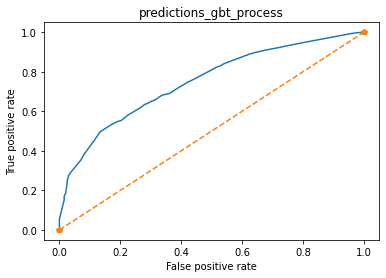

In [43]:
selected_predictions = predictions_gbt_process.select(["probability", "attack"])
selected_predictions_collect = selected_predictions.collect()
prediction_list = [(float(value[0][0]), 1.0 - float(value[1])) for value in selected_predictions_collect]

SandL = sc.parallelize(prediction_list)

result_metrix = bcm(SandL)

false_PR = dict()
true_PR = dict()
AUC = dict()

test = [i[1] for i in prediction_list]
result = [i[0] for i in prediction_list]

false_PR, true_PR, _ = roc_curve(test, result)
AUC = auc(false_PR, true_PR)

%matplotlib inline
plt.figure()
plt.plot(false_PR, true_PR, label = "ROC CURVE" % AUC)
plt.plot([0,1], [0,1], 'p--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("predictions_gbt_process")
plt.show()

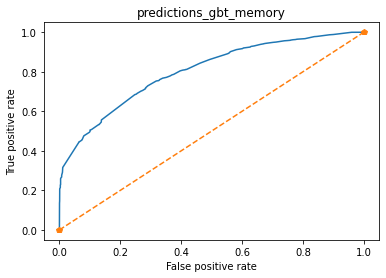

In [44]:
selected_predictions = predictions_gbt_memory.select(["probability", "attack"])
selected_predictions_collect = selected_predictions.collect()
prediction_list = [(float(value[0][0]), 1.0 - float(value[1])) for value in selected_predictions_collect]

SandL = sc.parallelize(prediction_list)

result_metrix = bcm(SandL)

false_PR = dict()
true_PR = dict()
AUC = dict()

test = [i[1] for i in prediction_list]
result = [i[0] for i in prediction_list]

false_PR, true_PR, _ = roc_curve(test, result)
AUC = auc(false_PR, true_PR)

%matplotlib inline
plt.figure()
plt.plot(false_PR, true_PR, label = "ROC CURVE" % AUC)
plt.plot([0,1], [0,1], 'p--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("predictions_gbt_memory")
plt.show()

According to the ROC curve, accuracy, recall and precision --> GBT model looks more promising.

Using the pipeline model selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.
- The models will be deployed in Part B of this project.

#### For Process Data:

In [45]:
count_attack_process = linux_process_cleaned.groupBy("attack").count().orderBy("attack")

total_non_attack_process = count_attack_process.where(col("attack") == 0).collect()[0][1]

total_attack_process = count_attack_process.where(col("attack") == 1).collect()[0][1]

ration_attack_process = (((total_attack_process)*0.2)*2)/total_non_attack_process

sampled_process_big = linux_process_cleaned.sampleBy("attack", fractions={0: ration_attack_process, 1: 0.2}, seed=0)

sampled_process_big_cached = sampled_process_big.cache()

In [49]:
categoryInputCols_process = ['State', 'Status', 'CMD']
numericInputCols_process = ['CPU', 'TSLPI', 'CPUNR']
numericOutputCol_process = 'attack'

allNumericCols_process = numericInputCols_process + [numericOutputCol_process]

outputCols_index = [f'{x}_index' for x in categoryInputCols_process]
inputIndexer = StringIndexer(inputCols=categoryInputCols_process, outputCols=outputCols_index)

inputCols_OHE = outputCols_index
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols_process]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

assemblerInputs = outputCols_OHE + numericInputCols_process
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

gbt_process = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_gbt = gbt_process

stages_gbt_process = [stage_1,stage_2,stage_3,stage_gbt]

pipeline_gbt_process = Pipeline(stages = stages_gbt_process)
pipelineModel_gbt_process = pipeline_gbt_process.fit(sampled_process_big_cached)

In [54]:
pipelineModel_gbt_process.save('attack_process_prediction_model')

#### For memory data:

In [55]:
count_attack_process = linux_memory_cleaned.groupBy("attack").count().orderBy("attack")

total_non_attack_process = count_attack_process.where(col("attack") == 0).collect()[0][1]

total_attack_process = count_attack_process.where(col("attack") == 1).collect()[0][1]

ration_attack_process = (((total_attack_process)*0.2)*2)/total_non_attack_process

sampled_process_big = linux_memory_cleaned.sampleBy("attack", fractions={0: ration_attack_process, 1: 0.2}, seed=0)

sampled_memory_big_cached = sampled_process_big.cache()

In [56]:
categoryInputCols_memory = ['CMD']
numericInputCols_memory = ['VSTEXT', 'RSIZE', 'MINFLT', 'MAJFLT']
numericOutputCol_memory = 'attack'

allNumericCols_memory = numericInputCols_memory + [numericOutputCol_memory]

In [57]:
outputCols_index = [f'{x}_index' for x in categoryInputCols_memory]
inputIndexer = StringIndexer(inputCols=categoryInputCols_memory, outputCols=outputCols_index).setHandleInvalid("skip")

inputCols_OHE = outputCols_index
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols_memory]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

assemblerInputs = outputCols_OHE + numericInputCols_memory
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

gbt_memory = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_gbt = gbt_memory

stages_gbt_memory = [stage_1, stage_2, stage_3, stage_gbt]

pipelineModel_gbt_memory = pipeline_gbt_memory.fit(sampled_memory_big_cached)

In [59]:
pipelineModel_gbt_memory.save('attack_memory_prediction_model')

![](jobs.png)

#### Since now we have highly accurate models trained on the static data, next step to apply this pipeline Machine Learning Model on real time streaming data to find out attacks and attackers in realtime.

## PART-B

In this part B, I am creating creating a proof-of-concept streaming application to demonstrate the integration of machine learning model, Kafka and Spark streaming and create real time visualisation for monitoring purpose.

Here I am creating proof-of-concept application for monitoring and detecting the attack in process and memory event data. To achieve this, I am simulating the streaming data production using Kafka, then showing some basic counts after consuming the data, and finally build a streaming application that integrates the machine learning model I made in part-A of project that can predict the attack to monitor the situation.


I do not have actual streaming data coiming to me through some api or something but I will try to find some way to create stream data through static data I have is Two files:
- Streaming_Linux_process.csv
- Streaming_Linux_memory.csv

In the bove streaming data files, machine ID and sequence of data is also added for each
memory activity and the process activity data, while the columns of “attack” and “type” are
not included.

You can download them from my [GitHub repository](https://github.com/RakeshNain/Cyber-Security-Application---Detecting-Linux-system-hacking-activities.git).

The streaming data files are an adapted version of process and memory data from the
Internet of Things dataset collected by Dr. Nour Moustafa, using IoT devices, Linux systems,
Windows systems, and network devices. For more detailed information on the dataset,
please refer to the Metadata file included in my GitHub repository or from the website
below https://ieee-dataport.org/documents/toniot-datasets.


Lets Start...

1st need to implement two Apache Kafka producers (one for process and one for memory) to simulate the real-time streaming of the data. For that I have created other two jupyter files one for process data real-time streaming data production and other one for memory data real-time streaming data production. They are in my [GitHub repository](https://github.com/RakeshNain/Cyber-Security-Application---Detecting-Linux-system-hacking-activities.git),their names are "memory peoducer" and "process producer" and I am going to run them paralalley

2nd, we will implement multiple Apache Kafka consumers to consume the data coming from the above producer.
For both the producers, I have created their respective consumers which will consumes the produced data using kafka consumer, and visualise the record counts in real time. And use charts/graphs to visualise.
Download both the consumers from my [Github repository](https://github.com/RakeshNain/Cyber-Security-Application---Detecting-Linux-system-hacking-activities.git) and run them. Thier names are "memory consumer" AND "process consumer".

#### Now, finally creating Streaming application using Spark Structured Streaming
I am implementing Spark Structured Streaming to consume the data from producers and perform predictive analytics in real time using Spark Structured Streaming together with Spark SQL and ML. I have already pre-trained models from Part-A of this project one for predicting attack in process data, another for predicting attack in memory data.

Few required imports.

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.types import *
import datetime as dt
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.ml import PipelineModel


Lets create SparkSession using a SparkConf object, which would use UTC as the timezone

In [ ]:
# local[2]: run Spark in local mode with 2 working processors as logical cores on your machine
master = "local[2]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment-2B-Task3"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

spark = SparkSession \
    .builder \
    .config(conf=spark_conf) \
    .config("spark.sql.session.timeZone", "UTC") \
    .getOrCreate()

From the Kafka producers, ingesting the streaming data into Spark Streaming for both process and memory activities

In [ ]:
# ingest the streaming data into Spark Streaming for memory
topic1 = "Streaming_Linux_memory5"
linux_memory = spark \
            .readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
            .option("subscribe", topic1) \
            .load()

In [ ]:
# ingest the streaming data into Spark Streaming for process
topic2 = "Streaming_Linux_process7"
linux_process = spark \
            .readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
            .option("subscribe", topic2) \
            .load()

In [ ]:
#showing data from memory producer
query = linux_memory \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("linux_memory_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [8]:
query.stop()

In [9]:
#Change the output sink to "memory" and write output to the memory sink
query = linux_process \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("linux_process_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [11]:
# wait few seconds before running it
spark.sql("select * from linux_process_tab").show()

+----+--------------------+--------------------+---------+------+--------------------+-------------+
| key|               value|               topic|partition|offset|           timestamp|timestampType|
+----+--------------------+--------------------+---------+------+--------------------+-------------+
|null|[5B 7B 22 73 65 7...|Streaming_Linux_p...|        0|    54|2020-11-01 11:52:...|            0|
|null|[5B 7B 22 73 65 7...|Streaming_Linux_p...|        0|    55|2020-11-01 11:52:...|            0|
|null|[5B 7B 22 73 65 7...|Streaming_Linux_p...|        0|    56|2020-11-01 11:52:...|            0|
+----+--------------------+--------------------+---------+------+--------------------+-------------+



In [12]:
query.stop()

In [13]:
# uncomment to see output on console
# query = linux_process \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [14]:
# query.stop()

Streaming data format transformed into the proper formats following the metadata file schema for both process and memory, similar to Part-A of project.
What is done:
- The numeric values with extra spaces or “K” / “M” / “G” are properly transformed into their correct values
- The NICE value are also restored based on the PRI values using their relationship

    - Note - There was mapping between PRI (priority) and NICE, as long as the process is not yet finished during the last interval. For example,
        - PRI 100 maps to NICE -20
        - PRI 101 maps toNICE -19
        - …
        - PRI 139 maps to NICE 19
    - Amd - If the process is finished, PRI and NICE would both be 0.

In [15]:
#transforming memory data into proper format

linux_memory = linux_memory.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

schema = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True), 
    StructField('MINFLT', IntegerType(), True),
    StructField('MAJFLT', IntegerType(), True), 
    StructField('VSTEXT', IntegerType(), True),
    StructField('VSIZE', IntegerType(), True), 
    StructField('RSIZE', IntegerType(), True),
    StructField('VGROW', IntegerType(), True),
    StructField('RGROW', IntegerType(), True), 
    StructField('MEM', IntegerType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', TimestampType(), True)            
]))

linux_memory = linux_memory.select(from_json(col("value").cast("string"), schema).alias('parsed_value'))

linux_memory = linux_memory.select(explode(col("parsed_value")).alias('unnested_value')) 

memory_df = linux_memory.select(
                    col("unnested_value.sequence").alias("sequence"),
                    col("unnested_value.machine").alias("machine"),
                    col("unnested_value.PID").alias("PID"),
                    col("unnested_value.MINFLT").alias("MINFLT"),
                    col("unnested_value.MAJFLT").alias("MAJFLT"),
                    col("unnested_value.VSTEXT").alias("VSTEXT"),
                    col("unnested_value.VSIZE").alias("VSIZE"),
                    col("unnested_value.RSIZE").alias("RSIZE"),
                    col("unnested_value.VGROW").alias("VGROW"),
                    col("unnested_value.RGROW").alias("RGROW"),
                    col("unnested_value.MEM").alias("MEM"),
                    col("unnested_value.CMD").alias("CMD"),
                    col("unnested_value.ts").alias("ts")
                )

In [16]:
#checking reformated memory data
query = memory_df \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("memory_df_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [18]:
# wait few seconds before running it
spark.sql("select * from memory_df_tab").show()

+--------+-------+----+------+------+------+-----+-----+-----+-----+---+--------------+-------------------+
|sequence|machine| PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|           CMD|                 ts|
+--------+-------+----+------+------+------+-----+-----+-----+-----+---+--------------+-------------------+
|    1982|      4|2530|     0|     1|    26|  337| 3148|    0|    0|  0|    gvfsd-fuse|2020-11-01 00:52:36|
|    1983|      4|2326|     0|     0|   245|40296| 2708|    0|    0|  0|          init|2020-11-01 00:52:36|
|    1984|      4|4327|  2500|     0|   148|18172| 2696|    0|    0|  0|          atop|2020-11-01 00:52:36|
|    1985|      4|4324|  2508|     0|   148|18172| 2676|    0|    4|  0|          atop|2020-11-01 00:52:36|
|    1986|      4|4325|  2500|     0|   148|18176| 2672|    0|    0|  0|          atop|2020-11-01 00:52:36|
|    1987|      4|4326|  2509|     0|   148|18172| 2664|    0|    0|  0|          atop|2020-11-01 00:52:36|
|    1988|      4|2420|     

In [19]:
query.stop()

In [20]:
# uncomment to see output on console

# query = memory_df \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [21]:
# query.stop()

In [22]:
#transformin process data into proper format

linux_process = linux_process.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

schema = ArrayType(StructType([    
    StructField('sequence', IntegerType(), True), 
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True), 
    StructField('TRUN', IntegerType(), True),
    StructField('TSLPI', IntegerType(), True), 
    StructField('TSLPU', IntegerType(), True),
    StructField('POLI', StringType(), True), 
    StructField('NICE', IntegerType(), True),
    StructField('PRI', IntegerType(), True),
    StructField('RTPR', IntegerType(), True), 
    StructField('CPUNR', IntegerType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', IntegerType(), True),
    StructField('State', StringType(), True), 
    StructField('CPU', IntegerType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', TimestampType(), True)            
]))

linux_process = linux_process.select(from_json(col("value").cast("string"), schema).alias('parsed_value'))

linux_process = linux_process.select(explode(col("parsed_value")).alias('unnested_value'))

process_df = linux_process.select(
                    col("unnested_value.sequence").alias("sequence"),
                    col("unnested_value.machine").alias("machine"),
                    col("unnested_value.PID").alias("PID"),
                    col("unnested_value.TRUN").alias("TRUN"),
                    col("unnested_value.TSLPI").alias("TSLPI"),
                    col("unnested_value.TSLPU").alias("TSLPU"),
                    col("unnested_value.POLI").alias("POLI"),
                    col("unnested_value.NICE").alias("NICE"),
                    col("unnested_value.PRI").alias("PRI"),
                    col("unnested_value.RTPR").alias("RTPR"),
                    col("unnested_value.CPUNR").alias("CPUNR"),
                    col("unnested_value.Status").alias("Status"),
                    col("unnested_value.EXC").alias("EXC"),
                    col("unnested_value.State").alias("State"),
                    col("unnested_value.CPU").alias("CPU"),
                    col("unnested_value.CMD").alias("CMD"),
                    col("unnested_value.ts").alias("ts")
                )

In [23]:
#checking reformated process data
query = process_df \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("process_df_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [24]:
# wait few seconds before running it
spark.sql("select * from process_df_tab").show()

+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+
|sequence|machine| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|                 ts|
+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+
|    1977|      4|4374|   0|    1| 1977|norm|  20|100|   0|    0|     -|  0|    S|  0|          atop|2020-11-01 00:52:59|
|    1978|      4|1442|   0|    1| 1978|norm|   0|120|   0|    2|     -|  0|    S|  0|          Xorg|2020-11-01 00:52:59|
|    1979|      4|3790|   0|    3| 1979|norm|   0|120|   0|    0|     -|  0|    S|  0|      ostinato|2020-11-01 00:52:59|
|    1980|      4|2797|   0|    5| 1980|norm|   0|120|   0|    2|     -|  0|    S|  0|      nautilus|2020-11-01 00:52:59|
|    1981|      4|2547|   0|    3| 1981|norm|   0|120|   0|    2|     -|  0|    S|  0|unity-panel-se|2020-11-01 00:52:59|
|    1982|      4|3155| 

In [25]:
query.stop()

In [26]:
# uncomment to see output on console

# query = process_df \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [27]:
# query.stop()

In [28]:
#renaming dataframes
linux_memory_cleaned = memory_df
linux_process_cleaned = process_df

In [29]:
# uncomment to see output on console

# query = linux_process_cleaned \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [30]:
# query.stop()

In [31]:
# fixing the errors in NICE column
def clean_nice(pri):
    return int(pri)-120
    
clean_nice_udf = udf(clean_nice, IntegerType())
linux_process_cleaned = linux_process_cleaned.withColumn('NICE', clean_nice_udf('PRI'))

In [32]:
# fixing the errors in NICE column
def fix_nice(cmd, nice):
    if "<" in cmd:
        return 0
    else:
        return int(nice)
    
fix_nice_udf = udf(fix_nice, IntegerType())
linux_process_cleaned = linux_process_cleaned.withColumn('NICE', fix_nice_udf('CMD', 'NICE'))

# fixing the errors in PRI column
def fix_pri(cmd, pri):
    if "<" in cmd:
        return 0
    else:
        return int(pri)
    
fix_pri_udf = udf(fix_pri, IntegerType())
linux_process_cleaned = linux_process_cleaned.withColumn('PRI', fix_pri_udf('CMD', 'PRI'))

In [33]:
#checking fixed process data
query = linux_process_cleaned \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("linux_process_cleaned_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [35]:
# wait few seconds before running it
spark.sql("select * from linux_process_cleaned_tab").show()

+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+
|sequence|machine| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|                 ts|
+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+
|    2203|      4|1442|   0|    1| 2203|norm|   0|120|   0|    0|     -|  0|    S|  0|          Xorg|2020-11-01 00:53:34|
|    2204|      4|2797|   0|    5| 2204|norm|   0|120|   0|    0|     -|  0|    S|  0|      nautilus|2020-11-01 00:53:34|
|    2205|      4|3155|   0|    4| 2205|norm|   0|120|   0|    0|     -|  0|    S|  0|gnome-terminal|2020-11-01 00:53:34|
|    2206|      4|8486|   0|    1| 2206|norm|   0|120|   0|    2|     -|  0|    S|  0|kworker/u256:1|2020-11-01 00:53:34|
|    2207|      4|2547|   0|    3| 2207|norm|   0|120|   0|    3|     -|  0|    S|  0|unity-panel-se|2020-11-01 00:53:34|
|    2208|      4|2420| 

In [36]:
query.stop()

For process and memory, respectively, creating a new column “CMD_PID” concatenating “CMD” and “PID” columns, and a new column “event_time” as timestamp format based on the unix time in “ts” column.

where, Allowing 20-second tolerance for possible data delay on “event_time” using watermarking.

In [37]:
# creating a new column “CMD_PID” concatenating “CMD” and “PID” columns
def concat(cmd, pid):
    return cmd+str(pid)
    
concat_udf = udf(concat, StringType())
linux_process_cleaned = linux_process_cleaned.withColumn('CMD_PID', concat_udf('CMD', 'PID'))
linux_memory_cleaned = linux_memory_cleaned.withColumn('CMD_PID', concat_udf('CMD', 'PID'))

In [38]:
# creating new column 'event_time' using 'ts' column 
# and setting 20-second tolerance for possible data delay on “event_time” using watermarking

linux_process_cleaned = linux_process_cleaned.withColumn('event_time', linux_process_cleaned.ts)
linux_process_cleaned = linux_process_cleaned.withWatermark("event_time", "20 seconds")

linux_memory_cleaned = linux_memory_cleaned.withColumn('event_time', linux_memory_cleaned.ts)
linux_memory_cleaned = linux_memory_cleaned.withWatermark("event_time", "20 seconds")

In [39]:
#checking new added columns in process data
query = linux_process_cleaned \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("linux_process_cleaned_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

# uncomment for checking new added columns in memory data
# query = linux_memory_cleaned \
#     .writeStream \
#     .outputMode("append") \
#     .format("memory") \
#     .queryName("linux_memory_cleaned_tab") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [40]:
# wait few seconds before running it
spark.sql("select * from linux_process_cleaned_tab").show()

# uncomment for checking new added columns in memory data
# spark.sql("select * from linux_memory_cleaned_tab").show()

+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+------------------+-------------------+
|sequence|machine| PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|                 ts|           CMD_PID|         event_time|
+--------+-------+----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+-------------------+------------------+-------------------+
|    2294|      4|1371|   0|    1| 2294|norm|   0|120|   0|    3|     -|  0|    S|  0|    irqbalance|2020-11-01 00:53:49|    irqbalance1371|2020-11-01 00:53:49|
|    2295|      4|3793|   1|   11| 2295|norm|   0|120|   0|    3|     -|  0|    S|  0|         drone|2020-11-01 00:53:49|         drone3793|2020-11-01 00:53:49|
|    2296|      4|6847|   0|    1| 2296|norm|   0|120|   0|    0|     -|  0|    S|  0|       tcpdump|2020-11-01 00:53:49|       tcpdump6847|2020-11-01 00:53:49|
|    2297|      4|2774|   0|    9|

In [41]:
query.stop()

In [42]:
# uncomment to see output on console

# query = linux_memory_cleaned \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [43]:
# query.stop()

Persisting the transformed streaming data in parquet format for both process and memory.

In [44]:
# transformed streaming data in parquet format for process data
parquet_process_query = linux_process_cleaned.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process")\
        .option("checkpointLocation", "process_parquet_checkpoint")\
        .start()

In [45]:
#stopping above query
parquet_process_query.stop()

In [46]:
# transformed streaming data in parquet format for memory data
parquet_memory_query = linux_memory_cleaned.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory")\
        .option("checkpointLocation", "memory_parquet_checkpoint")\
        .start()

In [47]:
#stopping above query
parquet_memory_query.stop()

Loading the machine learning models saved in Part-A of this project and use the models to predict whether
each process or memory streaming record is an attack event, respectively.

In [48]:
## uncomment to unzip the models
# import zipfile
# with zipfile.ZipFile("memory_pipeline_model.zip","r") as zip_ref:
#     zip_ref.extractall("memory_pipeline_model")

# loading the models
process_model = PipelineModel.load('process_pipeline_model/process_pipeline_model')
memory_model = PipelineModel.load('memory_pipeline_model/memory_pipeline_model')

In [49]:
# doing prediction
process_prediction = process_model.transform(linux_process_cleaned)
memory_prediction = memory_model.transform(linux_memory_cleaned)

In [50]:
# uncomment to see output on console

# query = process_prediction \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [51]:
# query.stop()

Using the prediction result, and monitor the data following the requirements below
- a) If any program in one machine is predicted as an attack in EITHER process
    or memory activity prediction, it could be a false alarm or a potential attack.
    Keeping track of the approximate count of such events in every 2-min window
    for each machine for process and memory, respectively, and writing the stream
    into Spark Memory sink using complete mode
    - My aggregated result include machine ID, the time window, and the counts
    - Note that if there are more than one entries having the SAME “CMD_PID” in a 2-min window, then I am getting the approximate distinct count. For example, if two or more records of “atop” program with the exact same “CMD_PID” are predicted as an attack in the process between 2020-10-10 10:10:10 and 2020-10-10 10:11:09 , only counting this “atop” program attack once.

In [52]:
# for process data
# groupby with machine and counting distinct (CMD+PID) for each group in the window of 2 minutes
process_attacksCounts = process_prediction.filter(col("prediction") == 1.0)\
    .groupBy(window(process_prediction.event_time, "120 seconds"), "machine")\
    .agg(approx_count_distinct("CMD_PID").alias("total_attacks"))\
    .select("window", "machine", "total_attacks")

In [53]:
#checking working of above code
query = process_attacksCounts \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("process_attacksCounts_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [58]:
# wait few minutes before running it
spark.sql("select * from process_attacksCounts_tab").show()

+--------------------+-------+-------------+
|              window|machine|total_attacks|
+--------------------+-------+-------------+
|[2020-11-01 00:54...|      6|          101|
|[2020-11-01 00:54...|      7|           88|
|[2020-11-01 00:54...|      8|           74|
|[2020-11-01 00:54...|      5|          185|
+--------------------+-------+-------------+



In [59]:
query.stop()

In [60]:
# uncomment to see output on console

# query = process_attacksCounts \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='10 seconds') \
#     .start()

In [61]:
# query.stop()

In [62]:
# for memory data
# groupby with machine and counting distinct (CMD+PID) for each group in the window of 2 minutes
memory_attacksCounts = memory_prediction.filter(col("prediction") == 1.0)\
    .groupBy(window(memory_prediction.event_time, "120 seconds"), "machine")\
    .agg(approx_count_distinct("CMD_PID").alias("total_attacks"))\
    .select("window", "machine", "total_attacks")

In [63]:
#checking working of above code
query = memory_attacksCounts \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("memory_attacksCounts_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [65]:
# wait few minutes before running it
spark.sql("select * from memory_attacksCounts_tab").show()

+--------------------+-------+-------------+
|              window|machine|total_attacks|
+--------------------+-------+-------------+
|[2020-11-01 00:46...|      4|           22|
|[2020-11-01 00:54...|      6|           19|
|[2020-11-01 00:50...|      7|            8|
|[2020-11-01 00:48...|      4|           28|
|[2020-11-01 00:46...|      8|            5|
|[2020-11-01 00:52...|      4|           11|
|[2020-11-01 00:48...|      5|            6|
|[2020-11-01 00:54...|      7|            9|
|[2020-11-01 00:48...|      7|           19|
|[2020-11-01 00:54...|      8|            5|
|[2020-11-01 00:52...|      6|            3|
|[2020-11-01 00:46...|      5|            9|
|[2020-11-01 00:48...|      8|            4|
|[2020-11-01 00:50...|      4|           16|
|[2020-11-01 00:50...|      5|           12|
|[2020-11-01 00:52...|      7|           16|
|[2020-11-01 00:52...|      8|            3|
|[2020-11-01 00:46...|      7|           17|
|[2020-11-01 00:50...|      8|            6|
|[2020-11-

In [66]:
query.stop()

In [67]:
# uncomment to see output on console

# query = memory_attacksCounts \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='10 seconds') \
#     .start()

In [68]:
# query.stop()

- b) If a program in one machine, having the same “CMD” and “PID” in both
process and memory streaming data, is predicted as an attack in BOTH
process and memory activity prediction, then I am considered it as an attack
event. 
Finding the streaming events fulfilling the criteria, creating a new column to record the processing time and persist them in parquet.

    - Note the program with the same “CMD” and “PID” might not be generated at the exact same event time. If the difference between the event times in process and memory is less than 30 seconds and the program fulfills the criteria of matching “CMD” and “PID”, then I am including them for the above checking.
    - If there are multiple entries fulfilling the above criteria in process or memory, not removing the extra entries
    - Persisting the program’s relevant information (including process & memory data, process & memory’s event and processing timestamp, and prediction result) into parquet format with the name of “process_memory_attack.parquet”

In [69]:
# remaning column names so that there will be no confusion after joing both the tables

memory_prediction_c = process_prediction.select(*(col(x).alias(x + '_m') for x in process_prediction.columns))

process_prediction_c = memory_prediction.select(*(col(x).alias(x + '_p') for x in memory_prediction.columns))

In [70]:
# joining tables on CMD_PID column
joined_df = memory_prediction_c.join(process_prediction_c, on = (memory_prediction_c["CMD_PID_m"] == process_prediction_c["CMD_PID_p"]) &  (memory_prediction_c["prediction_m"] == process_prediction_c["prediction_p"]), how = "inner")\
            .select(process_prediction_c["CMD_PID_p"], process_prediction_c["machine_p"], process_prediction_c["event_time_p"], memory_prediction_c["event_time_m"], process_prediction_c["prediction_p"], memory_prediction_c["prediction_m"])

In [71]:
# uncomment to see output on console

# query = joined_df \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [72]:
# query.stop()

In [73]:
#creating new column time_diff in joined table which will be helpful in indentif6ing attack
def time_diff(event_time_p, event_time_m):
    
    if event_time_p > event_time_m:
        td = event_time_p - event_time_m
    else:
        td = event_time_m - event_time_p
        
    return int(td.total_seconds())

time_diff_udf = udf(time_diff, IntegerType())

joined_df = joined_df.withColumn('time_diff', time_diff_udf('event_time_p', 'event_time_m'))

In [74]:
# uncomment to see output on console

# query = joined_df \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [75]:
# query.stop()

In [76]:
# creating a new column to record the processing time
joined_df = joined_df.withColumn('process_time', current_timestamp())

In [77]:
#filtering out joined row which have more than 30 seconds of time difference
# and also selecting row only which are prediction = attack
attack_joined_df = joined_df.filter(col("time_diff") > 30).filter((col("prediction_p") == 1.0) & (col("prediction_m") == 1.0))

In [78]:
attacks_Counts = attack_joined_df \
    .groupBy(window(attack_joined_df.event_time_p, "120 seconds"), "machine_p")\
    .agg(sum(attack_joined_df["prediction_p"]).alias("total_attacks"))\
    .select("window", "machine_p", "total_attacks")

In [79]:
#checking working of above code
query = attacks_Counts \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("attacks_Counts_tab") \
    .trigger(processingTime='5 seconds') \
    .start()

In [82]:
# wait few minutes before running it
spark.sql("select * from attacks_Counts_tab").show()

+--------------------+---------+-------------+
|              window|machine_p|total_attacks|
+--------------------+---------+-------------+
|[2020-11-01 00:46...|        4|         18.0|
|[2020-11-01 00:54...|        6|          9.0|
|[2020-11-01 00:48...|        4|         18.0|
|[2020-11-01 00:52...|        4|         12.0|
|[2020-11-01 00:48...|        5|         40.0|
|[2020-11-01 00:56...|        4|         28.0|
|[2020-11-01 00:56...|        5|         64.0|
|[2020-11-01 00:52...|        6|          6.0|
|[2020-11-01 00:46...|        5|         58.0|
|[2020-11-01 00:50...|        4|         22.0|
|[2020-11-01 00:50...|        5|         86.0|
|[2020-11-01 00:52...|        5|         74.0|
|[2020-11-01 00:56...|        6|         78.0|
|[2020-11-01 00:54...|        5|        110.0|
|[2020-11-01 00:54...|        4|         30.0|
+--------------------+---------+-------------+



In [83]:
query.stop()

In [84]:
# uncomment to see output on console

# query = attacks_Counts \
#     .writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .trigger(processingTime='5 seconds') \
#     .start()

In [85]:
# query.stop()

In [86]:
# Persist the program’s relevant information into parquet format
attacks_Counts_query = attacks_Counts.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process_memory_attack")\
        .option("checkpointLocation", "attacks_Counts_checkpoint")\
        .start()

In [87]:
attacks_Counts_query.stop()